In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PlotSettings import MainColor1, MainColor2, MainColor3, BackgroundColor3, BackgroundColor1, BackgroundColor2, Gray1, Gray2
from CrossSections import  sigmaV_to_ZZ_Approx, Transfer_sigma
from Constants import DensityFactor, Mp, mm

from scipy.integrate import quad, odeint
from scipy import misc, special, optimize

import matplotlib.patches as mpatches




## Small Scales (SIDM)

C:\Users\Nicolás\AppData\Local\Temp\ipykernel_12176\2459219669.py:55: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


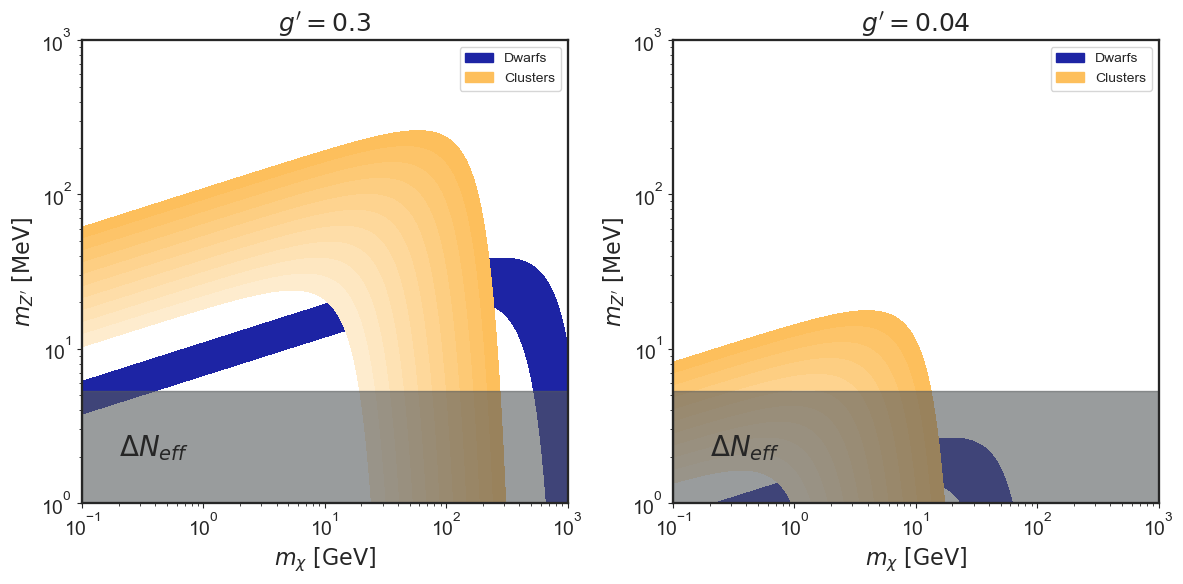

In [7]:
gp_l = (0.3, 4e-2)  

g_p = 200 #Grid Points
M_l = np.logspace(0, 3, g_p)
m_l = np.logspace(-1, 3, g_p)

#Grids
M_g, m_g = np.meshgrid(M_l, m_l)
sigma_grid_dwarf = np.zeros((g_p, g_p))
sigma_grid_clusters = np.zeros((g_p, g_p))

n = 10
levels_dw=[10, 70]
levels_cl= np.logspace(-3, 0.1, n+1)  # Generate logarithmically spaced values
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax = ax.ravel()

fig_index = 0

patch_dw = mpatches.Patch(color=MainColor1, label=r'Dwarfs')
patch_cl = mpatches.Patch(color=BackgroundColor2, label=r'Clusters')

def colorFader(c1,c2,mix=0): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    c1=np.array(c1)
    c2=np.array(c2)
    return (1-mix)*c1 + mix*c2

c1 = BackgroundColor2  # yellow
c2 = (1, 1, 1)  # white
clf = [colorFader(c1, c2, (np.log10(l) + 3)/4) for l in levels_cl]

for g in gp_l:
    
    for i in range(g_p):
        for j in range(g_p):
            sigma_grid_dwarf[i, j] = Transfer_sigma(30, g, M_l[j], m_l[i])
            sigma_grid_clusters[i, j] = Transfer_sigma(1000, g, M_l[j], m_l[i])

    ax[fig_index].set_title('$g^{{\prime}} = {}$'.format(g))
    
    ax[fig_index].contourf(m_g, M_g, sigma_grid_dwarf, levels_dw, colors=(MainColor1,))
    ax[fig_index].contourf(m_g, M_g, sigma_grid_clusters, levels_cl, colors=clf)
    
    ax[fig_index].text(0.2, 2, r'$\Delta N_{eff}$', fontsize=20)    
    ax[fig_index].fill_between(m_l, M_l[0], 5.3, color=Gray1, alpha=0.6) 
    ax[fig_index].set_xlabel('$m_{\chi} ~[\mathrm{GeV} ]$' )
    ax[fig_index].set_ylabel('$m_{Z\'} ~[\mathrm{MeV} ]$' )
    ax[fig_index].set_xscale('log')
    ax[fig_index].set_yscale('log')
    ax[fig_index].legend(handles=[patch_dw, patch_cl], loc='upper right')

    fig_index +=1

fig.tight_layout()
fig.show()
fig.savefig("Plots/ParameterSpacePlot.pdf")
fig.savefig("Plots/ParameterSpacePlot.svg")

## Muon g-2

In [24]:


#Grid
g_p = 10
M_l = np.logspace(-3, 1, g_p)
g_l = np.logspace(-4, -1, g_p)
g_g, M_g = np.meshgrid(g_l, M_l)


""" 
Functions  //////////////////////////
"""

#### g - 2

#Functions
def integral(m):
    return quad(lambda x: mm**2*x**2*(1-x)/(x**2*mm**2 + (1-x)*m**2), 0, 1)[0]

def Delta_a(g, M, charge):    
    return g**2*charge/(4*np.pi**2) * integral(M)

#Delta a grid
def Delta_grid(charges):
    Da_grid = np.zeros((g_p, g_p))
    for i in range(g_p):
        for j in range(g_p):
            Da_grid[i, j] = Delta_a(g_l[j], M_l[i], charges[0])
    return Da_grid


"""
Importing data on constrains //////////////////////////
"""

# BaBar
BaBar_data = np.loadtxt("Data-Sets/Babar_exclusion.csv", delimiter=',')
Babar_x = BaBar_data[:,0]
Babar_y = BaBar_data[:,1]

# CCFR
CCFR_data = np.loadtxt("Data-Sets/Nu-trident_exclusion.csv", delimiter=',') 
CCFR_x = CCFR_data[:,0]
CCFR_y = CCFR_data[:,1]



## Relic Density

In [68]:


def gs_to_half(T):
    a, b, c = 10.2, 2.349, 0.252
    return a/(1 + np.exp( -b*(T - c)))

def Yeq(x):
    return 0.145*x**1.5*np.exp(-x)

X = np.logspace(np.log10(0),np.log10(100), int(1e4))

def dYdx(Y, x, σv, m):
    return - np.sqrt(np.pi*Mp**2/45) * gs_to_half(m/x)/x**2 * (Y**2-Yeq(x)**2) * m * σv

def Y(x, g, M, m):
    σv = sigmaV_to_ZZ_Approx(g, M, m)
    return odeint(dYdx, Yeq(x[0]), x, args=(σv, m))


def Log_Omega_h2(m):
    Oh2_g = np.zeros((g_p, g_p))
    for i in range(g_p):
        for j in range(g_p):
            Oh2_g[i,j] = Y(X, g_l[j], M_l[i], m)[-1,0]
    LogDF = np.log10(DensityFactor)
    return np.log10(Oh2_g*m) + LogDF



C:\Users\Nicolás\AppData\Local\Temp\ipykernel_12176\2795149158.py:8: RuntimeWarning: divide by zero encountered in log10
  X = np.logspace(np.log10(0),np.log10(100), int(1e4))


In [69]:
m = 1e-1
Oh2_g = np.zeros((g_p, g_p))
for i in range(g_p):
    for j in range(g_p):
        Oh2_g[i,j] = Y(x, g_l[j], M_l[i], m)[0][-1]



NameError: name 'x' is not defined

In [ ]:
for i in range(1):
    Y(x, g_l[3], M_l[i], m)[0][-1]

Yield for $M = 1MeV, g'=0.1, m=0.1 GeV$:

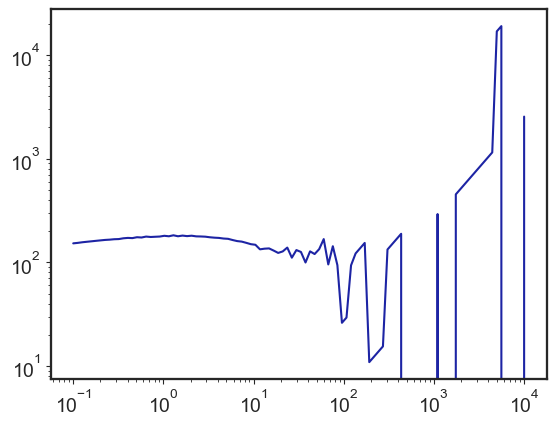

"\nOh2_grid = np.zeros((g_p, g_p))\nfor i in range(g_p):\n    for j in range(g_p):\n        Oh2_grid[i,j] = Y(X, sv_l[j], mDM_array[i])[0][-1]\n\n\n\n\nplt.contourf(m_grid, sv_grid, Oh2_grid, colors=(MainColor1,))\nplt.xlabel('$m_{\\chi} ~[\\mathrm{GeV} ]$' )\nplt.ylabel('$ \\sigma v$' )\nplt.xscale('log')\nplt.yscale('log')\nplt.show()\n"

In [70]:

#Grid
g_p = 20

mDM_array = np.logspace(0, 2.5, g_p)
sv_l = np.logspace(-20, -14, g_p)
sv_grid, m_grid = np.meshgrid(sv_l, mDM_array)


def gs_to_half(T):
    a, b, c = 10.2, 2.349, 0.252
    return a/(1 + np.exp( -b*(T - c)))

def Yeq(x):
    return 0.145*x**1.5*np.exp(-x)

X =np.logspace(np.log10(1),np.log10(100), int(1e5))

def dYdx(Y, x, σv, m, Mp):
    return - np.sqrt(np.pi/45)* Mp * m * σv * gs_to_half(m/x)/x**2 * (Y**2-Yeq(x)**2) 

def Y(x, m, σv, Mp):
    
    return odeint(dYdx, Yeq(x[0]), x, args=(σv, m, Mp), mxstep=100)

def Yinf(m, σv, Mp):
    return Y(X, m, σv, Mp)[-1,0]

def RelicDensity(m, σv, Mp):
    return DensityFactor*Yinf(m, σv, Mp)*m


mDM_array = np.logspace(-1, 4, 100)
σv = 1e-12

RD_array = [RelicDensity(mDM, σv, Mp=Mp) for mDM in mDM_array]
plt.loglog(mDM_array, RD_array, color=MainColor1)
plt.show()

"""
Oh2_grid = np.zeros((g_p, g_p))
for i in range(g_p):
    for j in range(g_p):
        Oh2_grid[i,j] = Y(X, sv_l[j], mDM_array[i])[0][-1]




plt.contourf(m_grid, sv_grid, Oh2_grid, colors=(MainColor1,))
plt.xlabel('$m_{\chi} ~[\mathrm{GeV} ]$' )
plt.ylabel('$ \sigma v$' )
plt.xscale('log')
plt.yscale('log')
plt.show()
"""

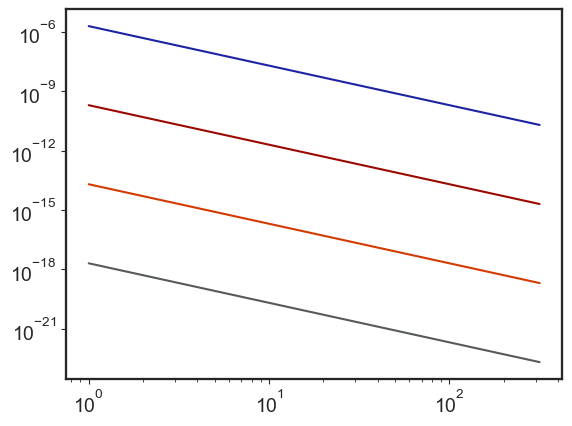

In [12]:
mDM_array = np.logspace(0, 2.5, 1000)
σv = 1e-15
#RD_array = [RelicDensity(mDM, σv) for mDM in mDM_array]
SigmaV_array_1 = [sigmaV_to_ZZ_Approx(0.1, mDM) for mDM in mDM_array]
SigmaV_array_2 = [sigmaV_to_ZZ_Approx(0.01, mDM) for mDM in mDM_array]
SigmaV_array_3 = [sigmaV_to_ZZ_Approx(0.001, mDM) for mDM in mDM_array]
SigmaV_array_4 = [sigmaV_to_ZZ_Approx(0.0001, mDM) for mDM in mDM_array]

#plt.loglog(mDM_array, RD_array, color=MainColor1)
plt.loglog(mDM_array, SigmaV_array_1, color=MainColor1)
plt.loglog(mDM_array, SigmaV_array_2, color=MainColor2)
plt.loglog(mDM_array, SigmaV_array_3, color=MainColor3)
plt.loglog(mDM_array, SigmaV_array_4, color=Gray1)
plt.show()

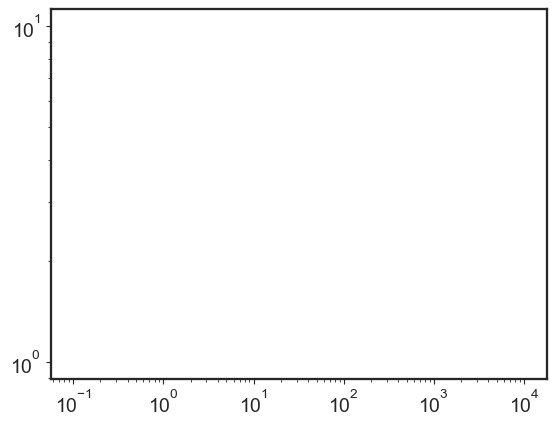